In [26]:

%load_ext autoreload
%autoreload 2 
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import torch
import json
from utils import (
    BiLSTMMultilabel,
    BiLSTMClassifier,
    BiLSTMClassifierMTL,
    SentenceEncoder,
    SentenceEncoder2,
    EmbeddingsDataset,
    load_documents_with_names,
    load_paths,
    load_crf_constraints,
    custom_collator,
    evaluate_model)
from torch.utils.data import DataLoader
from transformers import XLMRobertaTokenizerFast, XLMRobertaModel
torch.cuda.empty_cache()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

cuda:1
NVIDIA L4


In [4]:
task = 'multilabel'

In [ ]:
LABELS_DICT_PATH = "dataset/labels_dict.json"

labels_dict = json.load(open(LABELS_DICT_PATH, "r"))
#constraints = load_crf_constraints("dataset/constraints.json")
data_paths = load_paths("dataset/split_paths.json")
train_documents = load_documents_with_names(data_paths['train'])
val_documents = load_documents_with_names(data_paths['val'])
test_documents = load_documents_with_names(data_paths['test'])

tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")
sentence_encoder_model = XLMRobertaModel.from_pretrained("xlm-roberta-base")
sentence_encoder = SentenceEncoder(sentence_encoder_model)

#print("Encoding training sequences...")
#trainset_save_path = "dataset/embeddings/train.pkl"
#trainset = EmbeddingsDataset(train_documents, tokenizer, sentence_encoder, device, labels_dict, task, return_labels=True)
#trainset.save(trainset_save_path)

#print("\nEncoding validation sequences...")
#valset_save_path = "dataset/embeddings/val.pkl"
#valset = EmbeddingsDataset(val_documents, tokenizer, sentence_encoder, device, labels_dict, task, return_labels=True)
#valset.save(valset_save_path)

print("\nEncoding testing sequences...")
testset_save_path = "dataset/embeddings/"+task+"_test.pkl"
testset = EmbeddingsDataset(test_documents, tokenizer, sentence_encoder, device, labels_dict, task, return_labels=True)
testset.save(testset_save_path)

In [9]:
# load training saved sequences
trainset_load_path = "dataset/embeddings/"+task+"_train.pkl"
valset_load_path = "dataset/embeddings/"+task+"_val.pkl"
testset_load_path = "dataset/embeddings/"+task+"_test.pkl"
trainset = EmbeddingsDataset.load(trainset_load_path)
valset = EmbeddingsDataset.load(valset_load_path)
testset = EmbeddingsDataset.load(testset_load_path)

Dataset loaded from dataset/embeddings/multilabel_train.pkl
Number of sequences loaded: 51

Dataset loaded from dataset/embeddings/multilabel_val.pkl
Number of sequences loaded: 5

Dataset loaded from dataset/embeddings/multilabel_test.pkl
Number of sequences loaded: 12



In [10]:
BATCH_SIZE = 8
MODEL_WEIGHTS_PATH = 'models/bestmodel.pt'

#model = BiLSTMClassifierMTL(num_labels=len(labels_dict), isTrain=False)
model = BiLSTMMultilabel(num_labels=len(labels_dict), isTrain=False)
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH), strict=False)
model.to(device)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collator)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collator)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collator)

Evaluating training set...


  0%|          | 0/7 [00:00<?, ?it/s]

--------------------------------------------------Classification Metrics--------------------------------------------------

Micro Precision: 0.9133
Micro Recall: 0.9925
Micro F1 Score: 0.9513
-----------------
Macro Precision: 0.6914
Macro Recall: 0.9946
Macro F1 Score: 0.7782
-----------------
Weighted Precision: 0.9413
Weighted Recall: 0.9925
Weighted F1 Score: 0.9613
-----------------
Exact match ratio: 0.8839
Hamming Loss (lower is better): 0.0153
-----------------
                         precision    recall  f1-score   support

                Article       0.99      0.99      0.99      6063
                  Begin       0.69      0.97      0.81       830
         Contract Title       0.45      1.00      0.62        54
                Exhibit       1.00      1.00      1.00      2828
Introduction of Parties       0.63      1.00      0.77       316
               Preamble       0.47      0.99      0.64       225
  Reference Number/Date       0.10      1.00      0.19         9
     

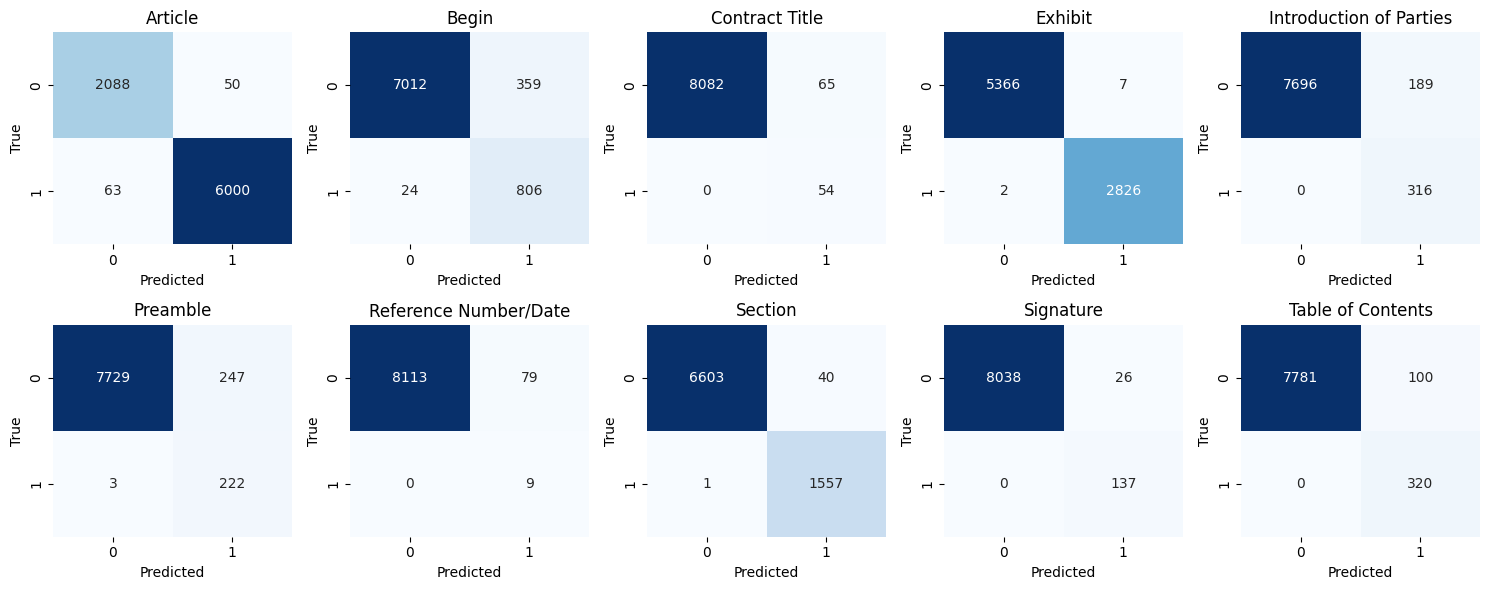

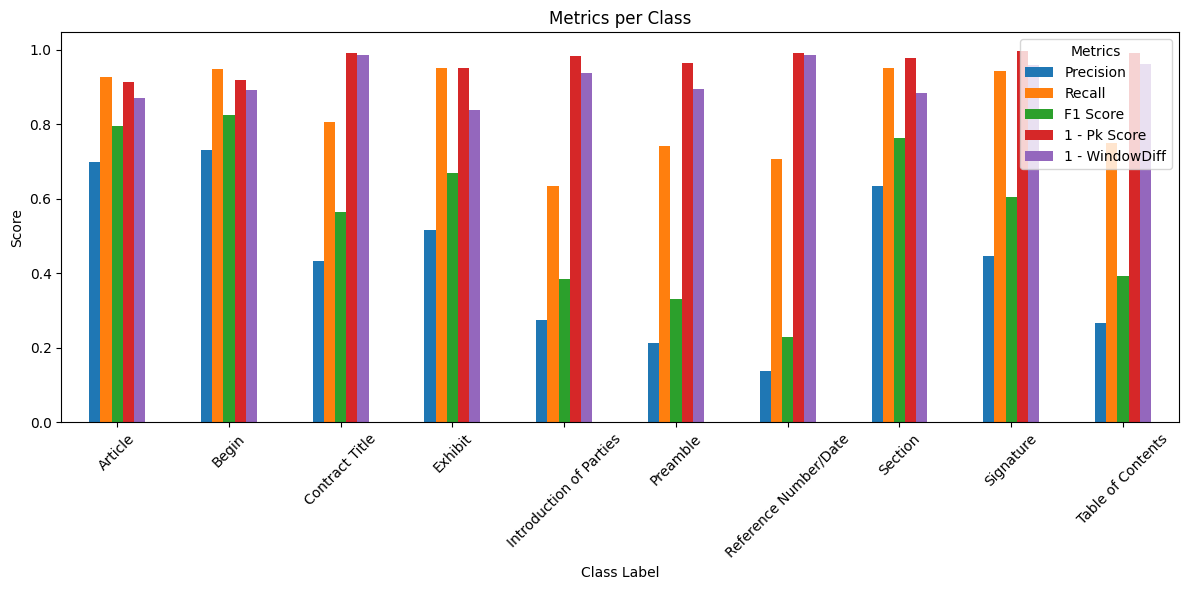

In [27]:
# evaluate trainset
print("Evaluating training set...")
evaluate_model(task=task, model=model, dataloader=train_loader, labels_dict=labels_dict, save_path="predictions/train", device=device)

Evaluating validation set...


  0%|          | 0/1 [00:00<?, ?it/s]

--------------------------------------------------Classification Metrics--------------------------------------------------

Micro Precision: 0.8257
Micro Recall: 0.9134
Micro F1 Score: 0.8673
-----------------
Macro Precision: 0.3938
Macro Recall: 0.6274
Macro F1 Score: 0.4469
-----------------
Weighted Precision: 0.8805
Weighted Recall: 0.9134
Weighted F1 Score: 0.8905
-----------------
Exact match ratio: 0.8170
Hamming Loss (lower is better): 0.0312
-----------------
                         precision    recall  f1-score   support

                Article       0.97      0.96      0.96       694
                  Begin       0.56      0.79      0.65        90
         Contract Title       0.54      1.00      0.70         7
                Exhibit       0.00      0.00      0.00        23
Introduction of Parties       0.18      1.00      0.31         6
               Preamble       0.12      0.83      0.22         6
  Reference Number/Date       0.00      0.00      0.00         0
     

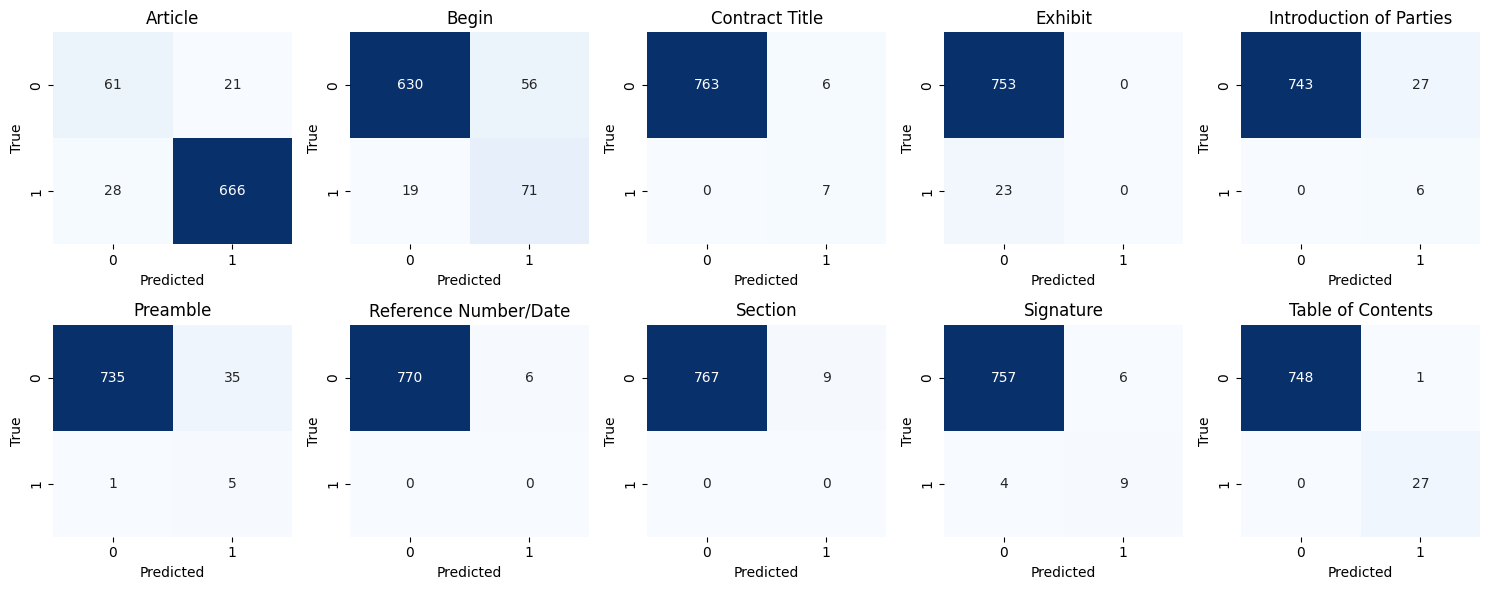

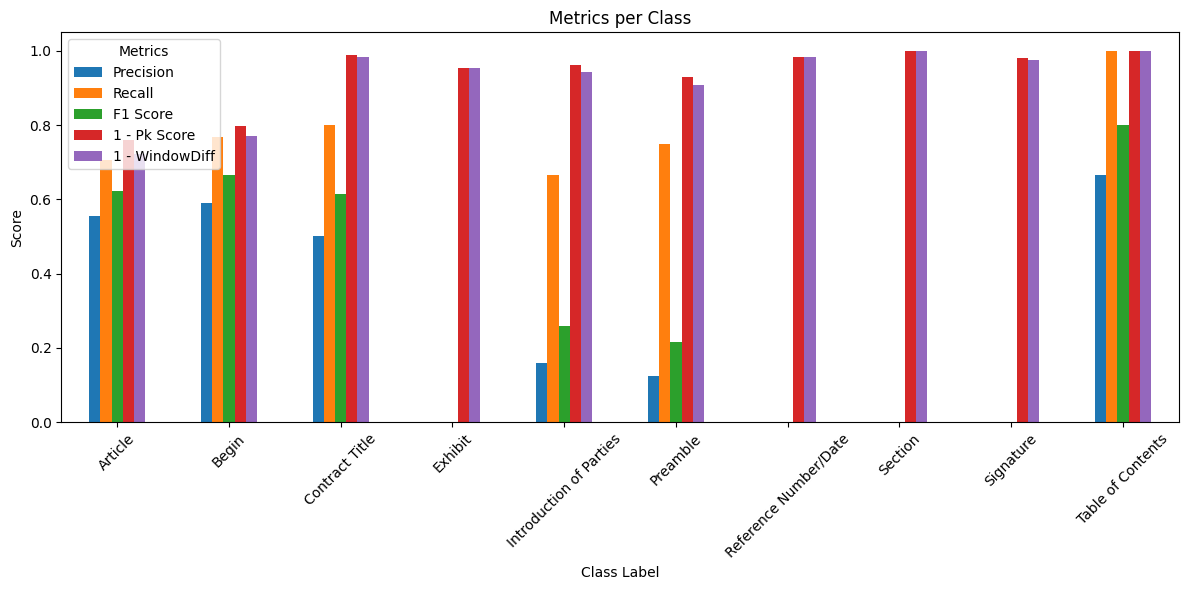

In [28]:
# evaluate valset
print("Evaluating validation set...")
evaluate_model(task=task, model=model, dataloader=val_loader, labels_dict=labels_dict, save_path="predictions/val", device=device)

Evaluating testing set...


  0%|          | 0/2 [00:00<?, ?it/s]

--------------------------------------------------Classification Metrics--------------------------------------------------

Micro Precision: 0.8849
Micro Recall: 0.6430
Micro F1 Score: 0.7448
-----------------
Macro Precision: 0.5442
Macro Recall: 0.6027
Macro F1 Score: 0.5048
-----------------
Weighted Precision: 0.9256
Weighted Recall: 0.6430
Weighted F1 Score: 0.7093
-----------------
Exact match ratio: 0.3854
Hamming Loss (lower is better): 0.0758
-----------------
                         precision    recall  f1-score   support

                Article       0.93      0.94      0.93      2486
                  Begin       0.35      0.74      0.48        88
         Contract Title       0.41      1.00      0.58         7
                Exhibit       1.00      0.34      0.51      2241
Introduction of Parties       0.58      0.66      0.62        74
               Preamble       0.43      0.30      0.36       106
  Reference Number/Date       0.00      0.00      0.00         1
     

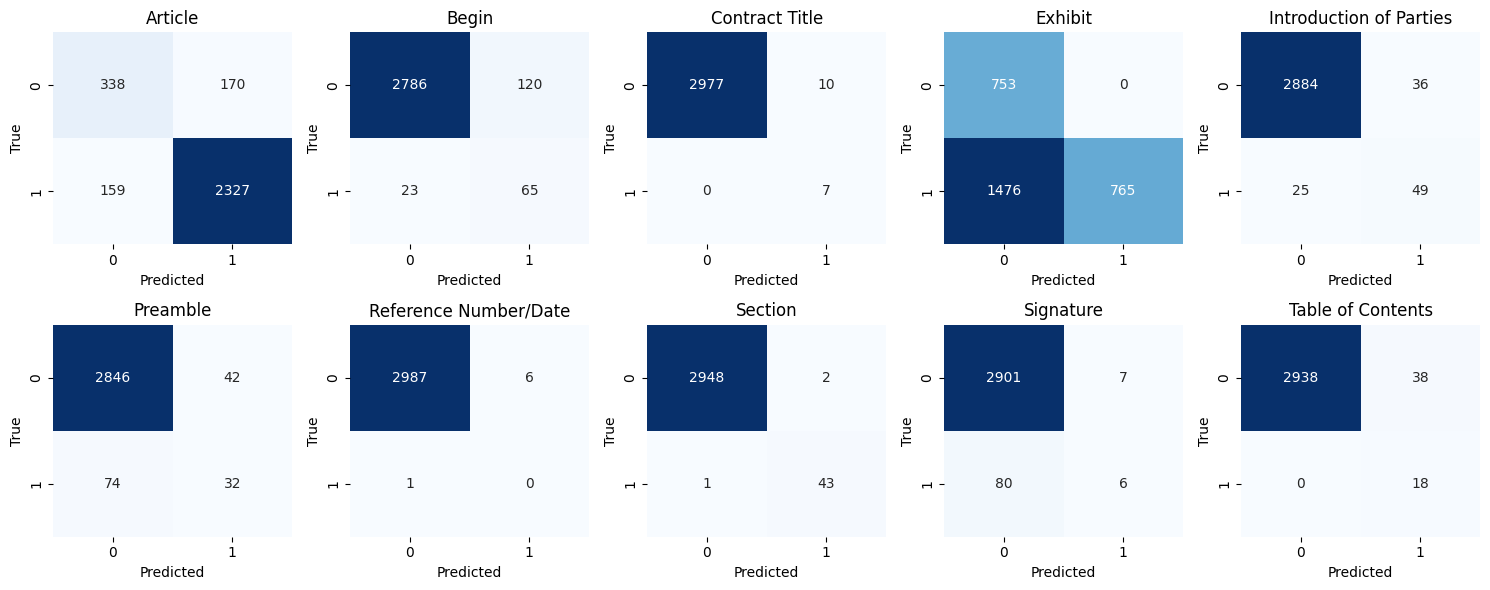

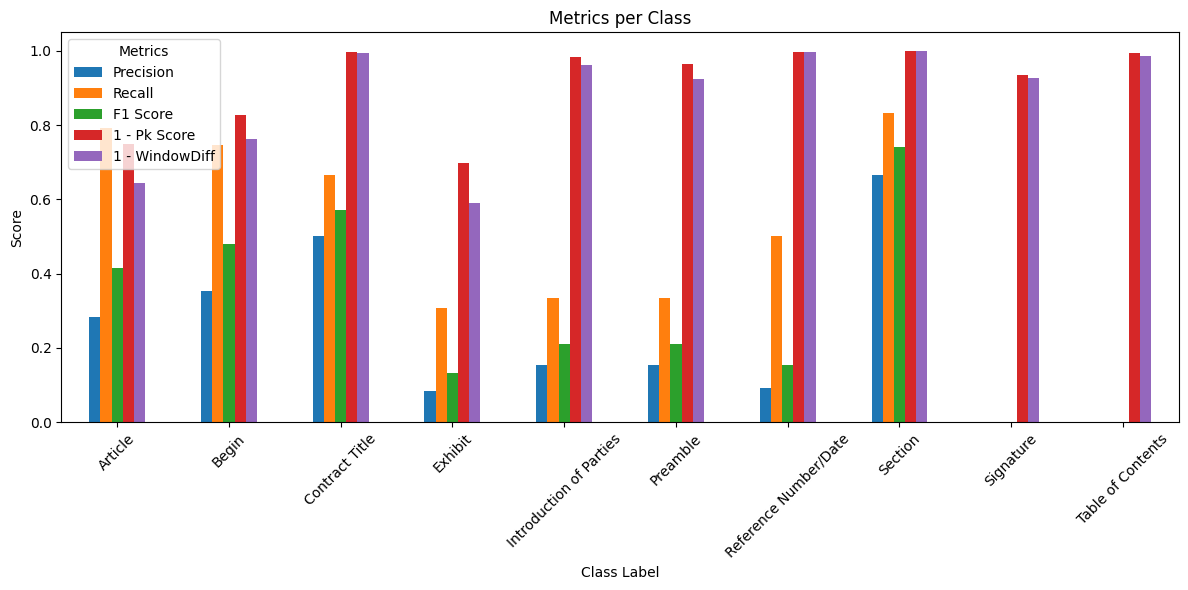

In [29]:
# evaluate testset
print("Evaluating testing set...")
evaluate_model(task=task, model=model, dataloader=test_loader, labels_dict=labels_dict, save_path="predictions/test", device=device)